In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os.path
import re
from PIL import Image
from io import BytesIO
from IPython.display import HTML
import base64


from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report
import seaborn as sns

# Keras imports
import keras
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam, SGD
from keras.models import load_model
from keras.models import Sequential, Model
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
# Set pandas options
pd.set_option('display.max_columns', None)

In [3]:
# Borrowed from a kaggle post to display images inside a dataframe
def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [4]:
# A function that counts the number of classes of images to train
def get_classes(path):
    """Returns the number of files and subdirectories in a directory. Intended
    to be used to count classes of images to use to train VGG19.
    Input: a filesystem path.
    Outpit: The number of files and subdirectories in a directory."""
    directories = glob(os.path.join(os.path.expanduser(path), '*'))
    return [dir.split('/')[-1] for dir in directories]
n_classes =  len(get_classes('~/p5/data/interim/train'))
n_classes

50

In [5]:
# Create a model based on a topless VGG19 model. 
vgg19 = keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224,224, 3))

In [6]:
# Add a new top to the VGG19 model
base_model = vgg19
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False 
    
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
predictions = Dense(n_classes, activation='softmax')(x) # should match # of classes predicted

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
# Show a summary of the model.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [8]:
# Set the paths of the train, validate, and test images.
train_path = os.path.expanduser('~/p5/data/interim/train')
test_path = os.path.expanduser('~/p5/data/interim/test')
valid_path = os.path.expanduser('~/p5/data/interim/valid')

In [9]:
# Create ImageDataGenerators to feed images to the model.
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224,224), 
                                                         batch_size=6)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, 
                                                         target_size=(224,224), 
                                                         batch_size=5)
test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(224,224),
                                                        shuffle=False,
                                                        batch_size=1)


Found 2766 images belonging to 50 classes.
Found 605 images belonging to 50 classes.
Found 543 images belonging to 50 classes.


In [10]:
# Compile the model
model.compile(Adam(lr=0.00002), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Train the model using early stopping, and checlpoints.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
hist = model.fit_generator(train_batches, 
                    steps_per_epoch=4, 
                    validation_data=valid_batches, 
                    validation_steps=4,
                    epochs=1,
                    verbose=2, 
                    callbacks=[es, mc])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
 - 18s - loss: 13.8005 - acc: 0.0000e+00 - val_loss: 15.3256 - val_acc: 0.0000e+00

Epoch 00001: val_acc improved from -inf to 0.00000, saving model to best_model.h5


In [12]:
# model.save('hieroglyphs_vgg19.h5')

In [13]:
model = load_model('hieroglyphs_vgg19.h5')

In [14]:
# Run test batches through the model to see how it performs.
STEP_SIZE_TEST=test_batches.n//test_batches.batch_size
test_batches.reset()
pred=model.predict_generator(test_batches,
steps=STEP_SIZE_TEST,
verbose=1)

543/543 [==============================] - 220s 405ms/step


In [15]:
# Get an array of the top predictions
predicted_class_indices = np.argmax(pred,axis=1)

In [16]:
# Use class indices to get the predicted classes. Compare them to their actual class
# and create a dataframe from this imformation
labels = (train_batches.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
pred_dict = {'predictions': predictions,
             'class_index': predicted_class_indices,
             'filename': test_batches.filenames}
df = pd.DataFrame(pred_dict)
df['glyph'] = df.apply(lambda row: re.match(r'^([A-Z]{1}\d+)/', row['filename']).group(1), axis=1)
df['match'] = df['predictions'] == df['glyph']
df['file_class_index'] = df.apply(lambda row: train_batches.class_indices[row['glyph']], axis=1)
df.head()

,predictions,class_index,filename,glyph,match,file_class_index
0,D2,0,D2/070242_D2.png,D2,True,0
1,D2,0,D2/220196_D2.png,D2,True,0
2,D21,1,D21/030269_D21.png,D21,True,1
3,D21,1,D21/030273_D21.png,D21,True,1
4,D21,1,D21/050286_D21.png,D21,True,1


In [17]:
# View some of the incorrect predictions
df[df['match'] == False].sample(10)

,predictions,class_index,filename,glyph,match,file_class_index
379,D28,2,Q3/200110_Q3.png,Q3,False,36
41,I9,18,D36/220005_D36.png,D36,False,4
339,O50,33,N5/070149_N5.png,N5,False,29
72,D35,3,E34/090216_E34.png,E34,False,9
15,E34,9,D21/220012_D21.png,D21,False,1
274,V31,44,N31/090182_N31.png,N31,False,26
275,V31,44,N31/220226_N31.png,N31,False,26
64,X1,48,E34/030164_E34.png,E34,False,9
327,X1,48,N35/410013_N35.png,N35,False,27
48,X1,48,D4/390007_D4.png,D4,False,5


In [18]:
# Calculate the accuracy of the predictions
acc = df['match'].sum() / len(df)
acc

0.9208103130755064

In [19]:
# Print the F1, and recall scores along with the classification report.
print('F1 Score:' , f1_score(df['file_class_index'], df['class_index'], average='weighted'))
print('\nRecall Score:' , recall_score(df['file_class_index'], df['class_index'], average='weighted'))
print('\nClassification Report:\n' , classification_report(df['file_class_index'], df['class_index']))

F1 Score: 0.9057478153725173

Recall Score: 0.9208103130755064

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.95      0.95      0.95        22
           2       0.75      1.00      0.86         3
           3       0.67      1.00      0.80         8
           4       1.00      0.88      0.93         8
           5       1.00      0.83      0.91         6
           6       0.83      0.71      0.77         7
           7       0.00      0.00      0.00         2
           8       1.00      1.00      1.00         6
           9       0.88      0.78      0.82        18
          10       0.71      0.83      0.77         6
          11       0.94      0.97      0.95        32
          12       1.00      1.00      1.00         3
          13       0.80      1.00      0.89         8
          14       1.00      1.00      1.00         2
          15       0.95      0.97      0.96    

/Applications/conda/anaconda3/envs/p5/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/conda/anaconda3/envs/p5/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


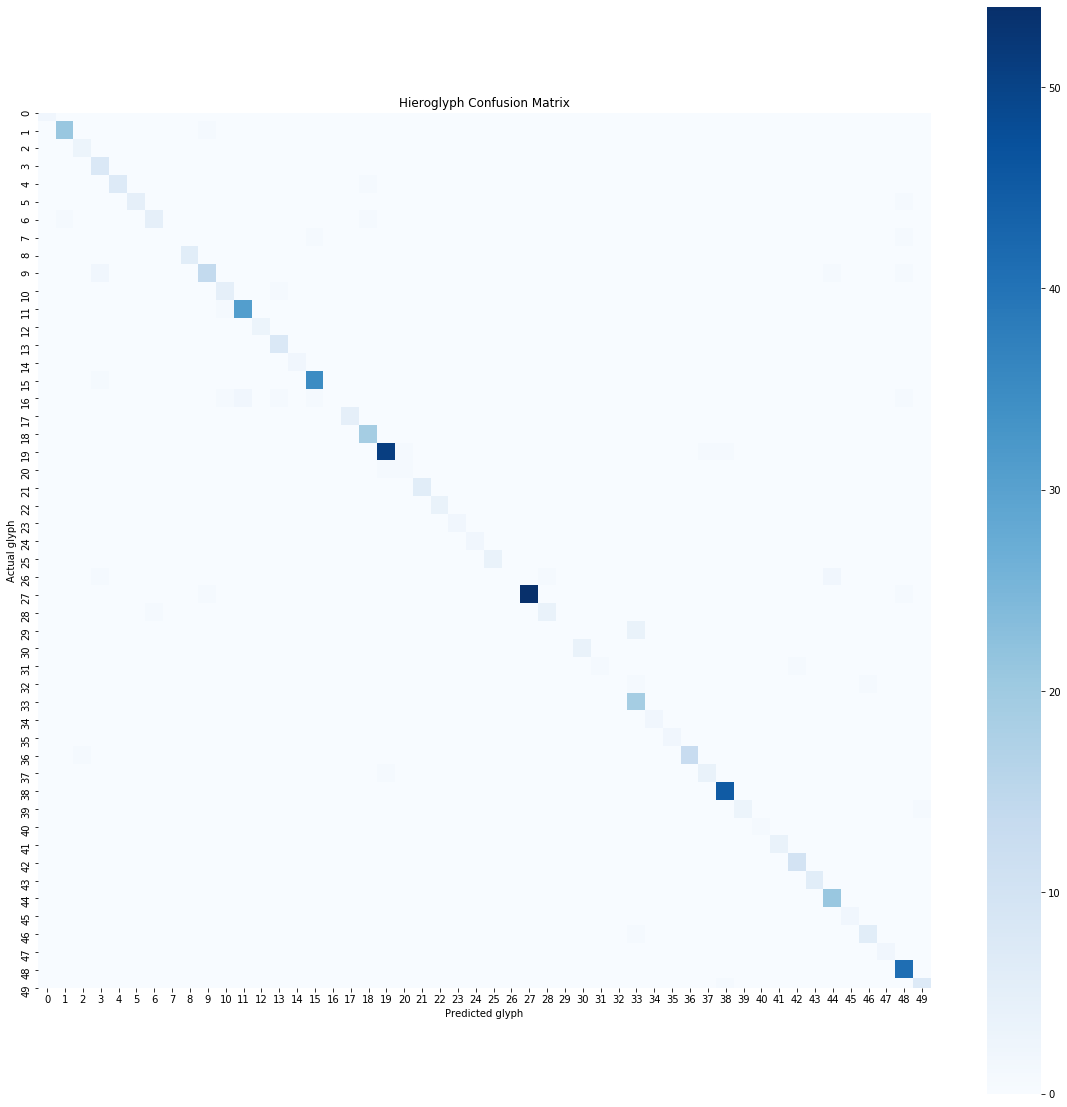

In [20]:
# Plot a confusion matrix for the hieroglyph classifications
glyph_confusion = confusion_matrix(df['file_class_index'], df['class_index'])
plt.figure(figsize=(20,20))
sns.heatmap(glyph_confusion, cmap=plt.cm.Blues, annot=False, square=True)#,

plt.xlabel('Predicted glyph')
plt.ylabel('Actual glyph')
plt.title('Hieroglyph Confusion Matrix');

In [21]:
m_classes =  len(get_classes('/Users/scott/p5/data/processed/modeling_all/train'))
m_classes

11

In [22]:
# Create a new model that will classify a smaller number of hieroglyphs, but of images contaminated
# with parts of surrounding glyphs.
base_model = keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224,224, 3))
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False 
    
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
predictions = Dense(m_classes, activation='softmax')(x) # should match # of classes predicted

# this is the model we will train
model2 = Model(inputs=base_model.input, outputs=predictions)

In [23]:
# Print model2. summary
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [24]:
# SEt path for the second model
train_path2 = os.path.expanduser('/Users/scott/p5/data/processed/modeling_all/train/')
test_path2 = os.path.expanduser('/Users/scott/p5/data/processed/modeling_all/test/')
valid_path2 = os.path.expanduser('/Users/scott/p5/data/processed/modeling_all/valid/')

In [25]:
# Create ImageDataGenerators to feed images to the model.
train_batches2 = ImageDataGenerator().flow_from_directory(train_path2, 
                                                         target_size=(224,224), 
                                                         batch_size=6)
valid_batches2 = ImageDataGenerator().flow_from_directory(valid_path2, 
                                                         target_size=(224,224), 
                                                         batch_size=5)
test_batches2 = ImageDataGenerator().flow_from_directory(test_path2, 
                                                        target_size=(224,224),
                                                        shuffle=False,
                                                        batch_size=1)

Found 3612 images belonging to 11 classes.
Found 451 images belonging to 11 classes.
Found 456 images belonging to 11 classes.


In [26]:
# Compile the second model
model2.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# Train the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300)
mc = ModelCheckpoint('best_model2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
hist = model2.fit_generator(train_batches2, 
                    steps_per_epoch=4, 
                    validation_data=valid_batches2, 
                    validation_steps=4,
                    epochs=1,
                    verbose=2, 
                    callbacks=[es, mc])

Epoch 1/1
 - 17s - loss: 9.2408 - acc: 0.0000e+00 - val_loss: 8.7756 - val_acc: 0.1500

Epoch 00001: val_acc improved from -inf to 0.15000, saving model to best_model2.h5


In [28]:
# Save the model
# model2.save('hieroglyphs_vgg19_custom_images_multiclass.h5')

In [29]:
# Load the model from a saved file
model2 = load_model('hieroglyphs_vgg19_N35_only_custom_images_multiclass.h5')

In [30]:
# Run the test batches to test model performance
STEP_SIZE_TEST=test_batches2.n//test_batches2.batch_size
test_batches2.reset()
pred = model2.predict_generator(test_batches2,
steps = STEP_SIZE_TEST,
verbose=1)

456/456 [==============================] - 182s 400ms/step


In [31]:
# Get predictions
predicted_class_indices=np.argmax(pred,axis=1)

In [32]:
# Get the labels for the predictions
labels = (train_batches2.class_indices)
print(labels)
labels = dict((v,k) for k,v in labels.items())
print(labels)
predictions = [labels[k] for k in predicted_class_indices]

{'N35': 0, 'basket': 1, 'bird': 2, 'cloth': 3, 'cobra': 4, 'mouth': 5, 'reed': 6, 'sun': 7, 'tether': 8, 'viper': 9, 'wick': 10}
{0: 'N35', 1: 'basket', 2: 'bird', 3: 'cloth', 4: 'cobra', 5: 'mouth', 6: 'reed', 7: 'sun', 8: 'tether', 9: 'viper', 10: 'wick'}


In [33]:
def get_glyph_name(series):
    """Returns the name of the for each element of the input series."""
    file = series['filename']
    m = re.match(r'^([a-z]+)/', file)
    n = re.match(r'^([A-Z]{1}\d+)/', file)
    if m:
        return m.group(1)
    elif n:
        return n.group(1)
    else:
        return 'unknown'

In [34]:
# Create a dataframe fromthe predictions
pred_df = pd.DataFrame(predictions, columns=['predicted'])
pred_df = pred_df.merge(pd.DataFrame(test_batches2.filenames, columns=['filename']), left_index=True, right_index=True)
pred_df['glyph'] = pred_df.apply(lambda row: get_glyph_name(row), axis=1)
pred_df['match'] = pred_df['predicted'] == pred_df['glyph']
pred_df.head()

,predicted,filename,glyph,match
0,N35,N35/img_x_101_y_264.png,N35,True
1,N35,N35/img_x_106_y_15.png,N35,True
2,N35,N35/img_x_113_y_127.png,N35,True
3,N35,N35/img_x_121_y_102.png,N35,True
4,N35,N35/img_x_127_y_205.png,N35,True


In [35]:
# Get accuracy
acc = pred_df['match'].sum() / len(pred_df)
acc

0.7763157894736842

In [36]:
def get_indices(series, idx_dict):
    """Returns a numpy array from indices for input series of class names."""
    indices = pd.Series(index=series.index)
    for idx, val in series.iteritems():
        indices[idx] = idx_dict[val]
    return indices

In [37]:
# Set y_true, and y_pred for f1_score, recall, and confusion matrixes
y_pred = get_indices(pred_df.predicted, train_batches2.class_indices)
y_true = get_indices(pred_df.glyph, train_batches2.class_indices)
f1_score(y_true, y_pred, average='weighted')

0.7730609270159422

In [38]:
# Print the F1, and recall scores along with the classification report.
print('F1 Score:' , f1_score(y_true, y_pred, average='weighted'))
print('\nRecall Score:' , recall_score(y_true, y_pred, average='weighted'))
print('\nClassification Report:\n' , classification_report(y_true, y_pred))

F1 Score: 0.7730609270159422

Recall Score: 0.7763157894736842

Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.89      0.87       118
         1.0       0.64      0.70      0.67        33
         2.0       0.91      0.95      0.93        44
         3.0       0.84      0.79      0.81        33
         4.0       0.67      0.63      0.65        19
         5.0       0.64      0.47      0.54        49
         6.0       0.85      0.79      0.82        58
         7.0       0.83      0.92      0.87        37
         8.0       0.62      0.56      0.59        18
         9.0       0.54      0.67      0.60        30
        10.0       0.76      0.76      0.76        17

    accuracy                           0.78       456
   macro avg       0.74      0.74      0.74       456
weighted avg       0.77      0.78      0.77       456



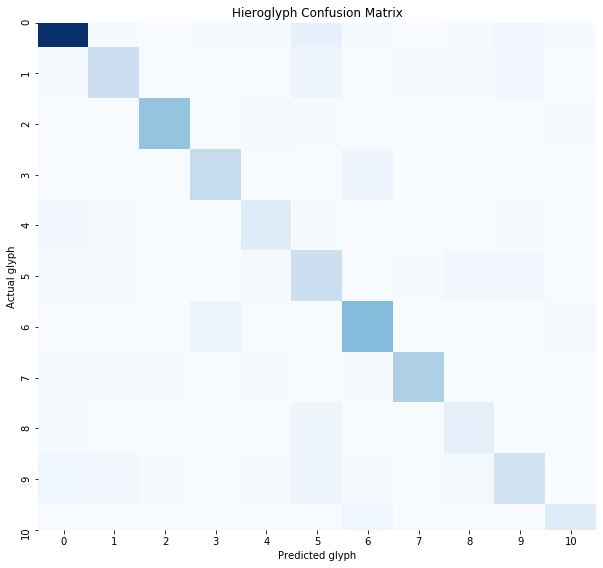

In [39]:
# Plot a confusion matrix for the hieroglyph classifications
glyph_confusion = confusion_matrix(y_pred, y_true)
plt.figure(figsize=(10,10))
sns.heatmap(glyph_confusion, cmap=plt.cm.Blues, annot=False, square=True, cbar=False)#,
plt.cbar = False

plt.xlabel('Predicted glyph')
plt.ylabel('Actual glyph')
plt.title('Hieroglyph Confusion Matrix');

In [40]:
# Create a thumbnail dataframe
tdf = pred_df.copy()
tdf.head()

,predicted,filename,glyph,match
0,N35,N35/img_x_101_y_264.png,N35,True
1,N35,N35/img_x_106_y_15.png,N35,True
2,N35,N35/img_x_113_y_127.png,N35,True
3,N35,N35/img_x_121_y_102.png,N35,True
4,N35,N35/img_x_127_y_205.png,N35,True


In [41]:
# Setup the thumbnail columns
tdf['pred_img'] = tdf.apply(lambda row: get_thumbnail(os.path.join('/Users/scott/p5/data/processed/modeling_all/test', row['filename'])), axis=1)

,predicted,filename,glyph,match,pred_img
401,mouth,tether/img_x_442_y_356.png,tether,False,
264,viper,mouth/img_x_28_y_535.png,mouth,False,
300,cloth,reed/img_x_146_y_171.png,reed,False,
285,N35,mouth/img_x_65_y_93.png,mouth,False,
210,N35,cloth/img_x_442_y_516.png,cloth,False,
426,mouth,viper/img_x_584_y_506.png,viper,False,
337,wick,reed/img_x_692_y_358.png,reed,False,
424,basket,viper/img_x_466_y_419.png,viper,False,
394,basket,tether/img_x_235_y_119.png,tether,False,
247,viper,mouth/img_x_129_y_205.png,mouth,False,

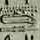
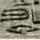
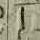
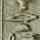
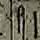
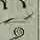
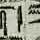
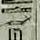
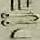
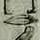
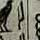
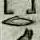
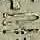
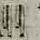
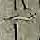
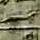
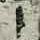
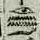
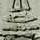
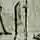
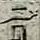
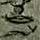
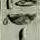
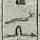
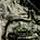
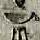
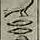
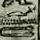
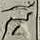
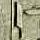

In [43]:
# Show some sample mismatches
HTML(tdf[tdf['match'] == False].sample(30).to_html(formatters={'pred_img': image_formatter}, escape=False))